# Best Subset Selection

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

We wish to predict `salary` on the basis of various performance statistics from the previous year.

In [ ]:
hitters_df = pd.read_csv('Hitters.csv')
print(hitters_df.shape)
print(hitters_df.head())
print("Number of null salary values:", hitters_df["Salary"].isnull().sum())

Remove observations with null `salary` values. The riginal code read `hitters_df_clean = hitters_df.dropna().drop('Player', axis=1)`. I didn't have a 'Player' along axis 1, but I could probably try using that method to strip things from future code. 

In [ ]:
hitters_df_clean = hitters_df.dropna()    
print("Cleaned data shape:", hitters_df_clean.shape)
print("Remaining null values:", hitters_df_clean["Salary"].isnull().sum())

Clean up categorical predictors using dummy variables. `pandas` can generate dummy variables, separate out the response variable, and glue it back together.

In [ ]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])
# print(dummies)
y = hitters_df_clean.Salary
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float')
# print(X_)
X = pd.concat([X_, dummies[['League_N', "Division_W", "NewLeague_N"]]], axis=1)
# print(X)

Perform best subset selection by identifying the best model containing a given number of predictors. **Best** is quantified using RSS. Create a function to output the best set of variables for each model size.

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS. OLS = ordinary least squares.
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [20]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
        
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest (?) RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return a `DataFrame` of the best model, along with some other useful information about it.
    return best_model

Call `getBest()` for each number of predictors `k`:

In [22]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)
    
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.014461994171142578 seconds.
Processed 171 models on 2 predictors in 0.09994697570800781 seconds.
Processed 969 models on 3 predictors in 0.5257110595703125 seconds.
Processed 3876 models on 4 predictors in 2.3355278968811035 seconds.
Processed 11628 models on 5 predictors in 6.781804084777832 seconds.
Processed 27132 models on 6 predictors in 16.67234492301941 seconds.
Processed 50388 models on 7 predictors in 31.255784034729004 seconds.
Total elapsed time: 58.00414299964905 seconds.


In [23]:
models_best

,RSS,model
1,43213925.909868,<statsmodels.regression.linear_model.Regressio...
2,30733054.433644,<statsmodels.regression.linear_model.Regressio...
3,29410713.176731,<statsmodels.regression.linear_model.Regressio...
4,27976782.522603,<statsmodels.regression.linear_model.Regressio...
5,27187795.009508,<statsmodels.regression.linear_model.Regressio...
6,26397720.512772,<statsmodels.regression.linear_model.Regressio...
7,26064130.610341,<statsmodels.regression.linear_model.Regressio...


In [24]:
print(models_best.loc[2, "model"].summary()) # Print the best two-variable model

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Mon, 04 Jul 2022   Prob (F-statistic):                    5.80e-82
Time:                        21:12:54   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [25]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.0027570724487304688 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Mon, 04 Jul 2022   Prob (F-statistic):                    1.31e-76
Time:                        21:15:18   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      

We can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [26]:
models_best.loc[2, "model"].rsquared

0.7614950002332873

Fitting the `OLM` also produced some other useful statistics, such as adjusted $R^2$, Akaike Information Criteria (AIC), and Bayesian Information Criteria (BIC). Start by looking at $R^2$ across all models:

In [29]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

Plotting RSS, adjusted $R^2$, AIC, and BIC for all models at once will help decide which model to select. Note the `type="1"` option tells python to connect the plotted points with lines.

Text(0, 0.5, 'BIC')

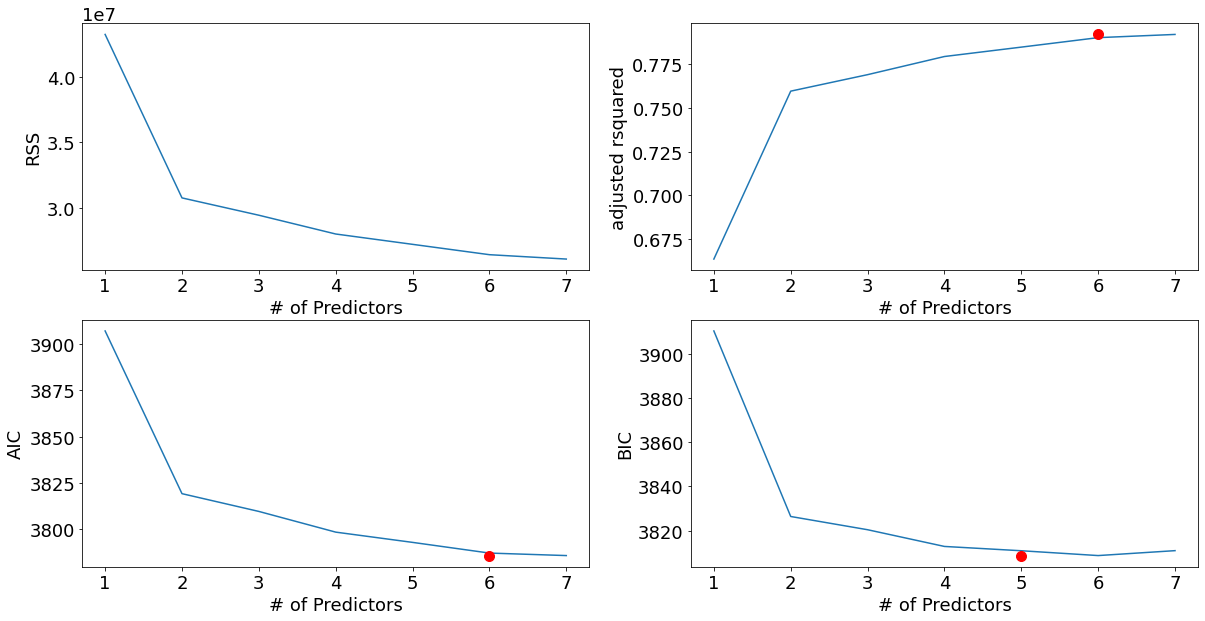

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up 2x2 grid to look at four plots at once
plt.subplot(2, 2, 1)
 
plt.plot(models_best["RSS"])
plt.xlabel('# of Predictors')
plt.ylabel('RSS')

# Plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector.
rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# of Predictors')
plt.ylabel('adjusted rsquared')

# Do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# of Predictors')
plt.ylabel('AIC')


bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# of Predictors')
plt.ylabel('BIC')


# Forward and Backward Stepwise Selection
*Finish the tutorial located [here](https://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html).*